In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
data = pd.read_csv('kc_house_data.csv')

In [81]:
og_data = pd.read_csv('kc_house_data.csv')

# The first round of column cuts

This is me coming back and dropping the columns I won't need yet. There will be further cuts to come. Most of these columns I feel like I could find something useful for, but ultimately I have a limited amount of time here.

In [4]:
# After the fact I'm coming back and removing columns I'm not using.

data = data.drop(['id', 'floors', 'lat', 'long', 'zipcode'], axis=1)

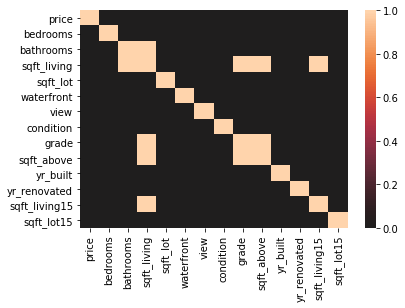

In [5]:
sns.heatmap(abs(data.corr()) > 0.75, center=0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1b9ce9e8>,
      dtype=object)

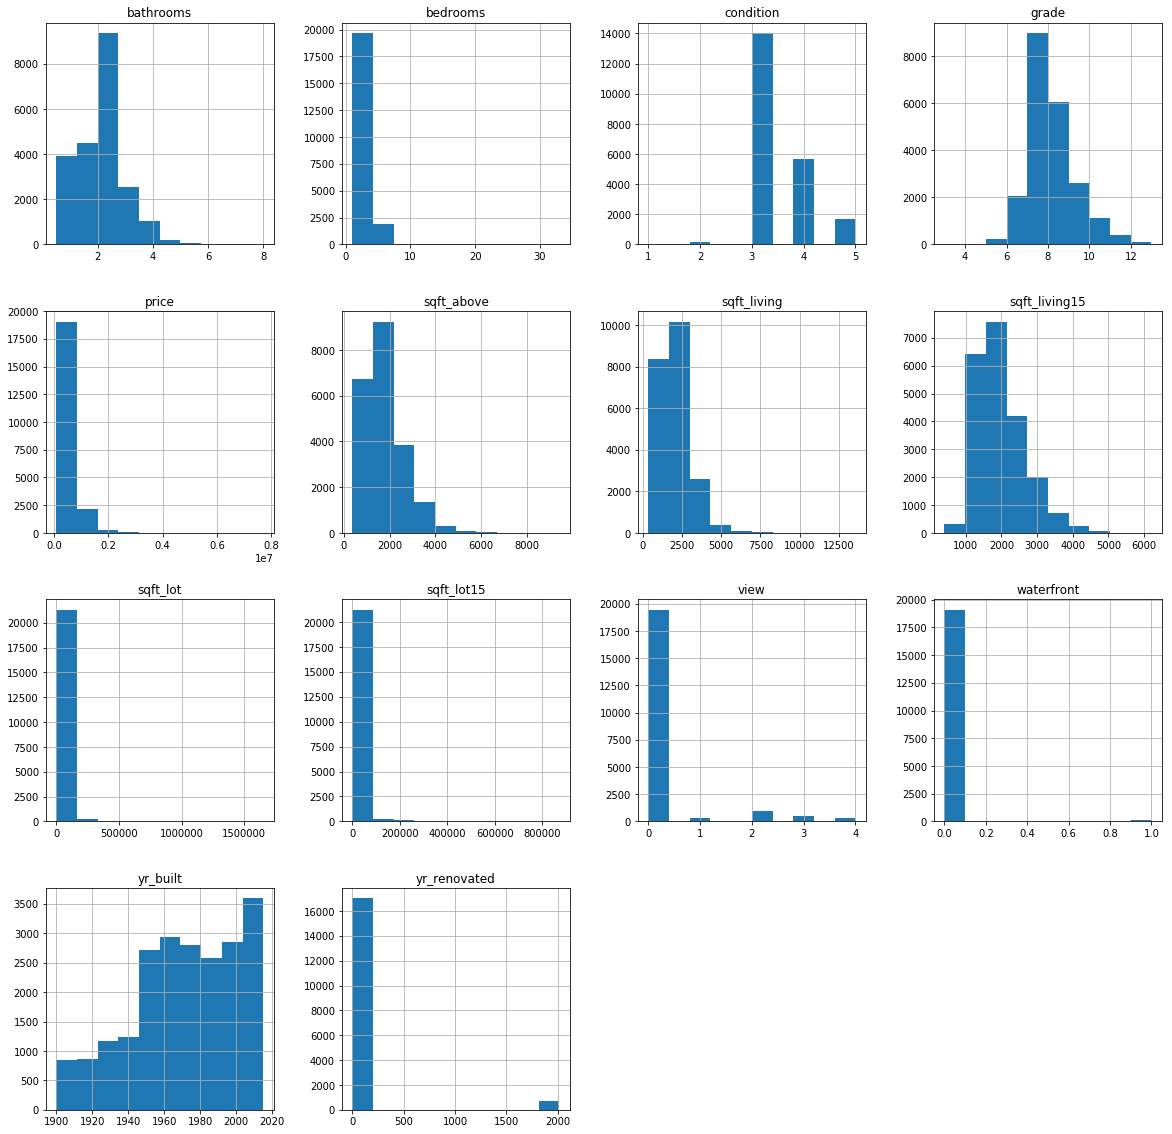

In [6]:
data.hist(figsize = (20,20))

# Removing Outliers
Okay, so there are some outliers that need to be removed before we can start making real moves. Bedrooms, bathrooms, sqft_living and sqft_lot jump out to me. Looking at their scatter graphs:

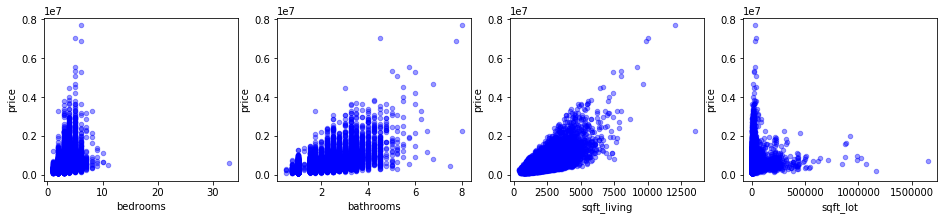

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['bedrooms', 'bathrooms',  'sqft_living', 'sqft_lot'], axes):
    data.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

In [8]:
# oh, what's up insane bedroom number? You are obivously user error. Let's get rid of you.
data = data[data.bedrooms < 10]

#ridding ouselves of the outliers in bathrooms.
# I don't believe that anyhting below a three quarter bath is not a mistake
# and I want to get rid of some of the max data.
data = data[data['bathrooms'] < 7.5]
data = data[data['bathrooms'] >= 0.5]

# I'm using the .999 quantile to remove the  outliers on the high and low end of the lot and square footage
data= data[data['sqft_lot'] < data.sqft_lot.quantile(.999)]
data= data[data['sqft_lot'] > data.sqft_lot.quantile(.001)]

data = data[data['sqft_living'] < data.sqft_living.quantile(.999)]
data = data[data['sqft_living'] > data.sqft_living.quantile(.001)]

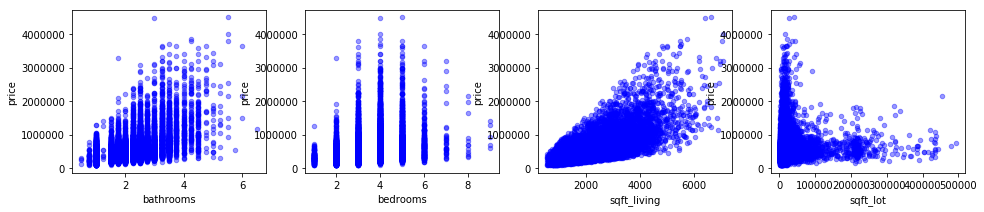

In [9]:
# Let's see the difference!

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['bathrooms', 'bedrooms', 'sqft_living', 'sqft_lot'], axes):
    data.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

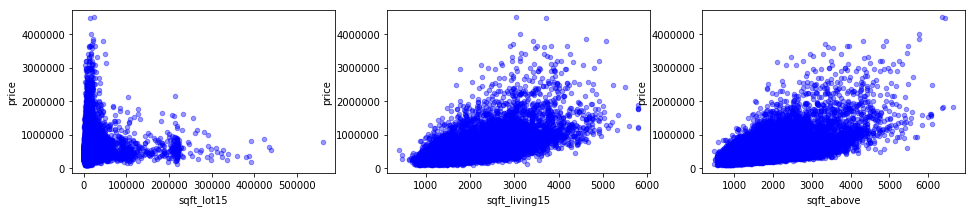

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))

for xcol, ax in zip(['sqft_lot15', 'sqft_living15',  'sqft_above'], axes):
    data.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

In [11]:
# If I'm gonna cut the neighbors, I've gotta cut the nearby lots
data = data[data.sqft_lot15 < data.sqft_lot.quantile(.999)]
data = data[data.sqft_lot15 > data.sqft_lot.quantile(.001)]

#ridding ouselves of the outliers in bathrooms.
# I don't believe that anyhting below a three quarter bath is not a mistake
# and I want to get rid of some of the max data.
data = data[data.sqft_living15 < data.sqft_living15.quantile(.999)]
data = data[data.sqft_living15 > data.sqft_living15.quantile(.001)]


# I'm using the .999 quantile to remove the  outliers on the high and low end of the lot and square footage.
# The graph looks a lit like Long Island. I grew up somewhere around 3000 sqft_above and $1000000
data = data[data.sqft_above < data.sqft_above.quantile(.999)]
data = data[data.sqft_above > data.sqft_above.quantile(.001)]

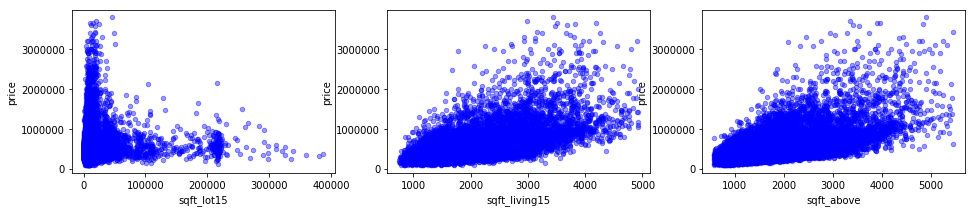

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,3))

for xcol, ax in zip(['sqft_lot15', 'sqft_living15',  'sqft_above'], axes):
    data.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

# What about price?

Yeah, we're trying to predict price, but I'm going back and inserting this late in my research to think about removing outliers because I never touched it.

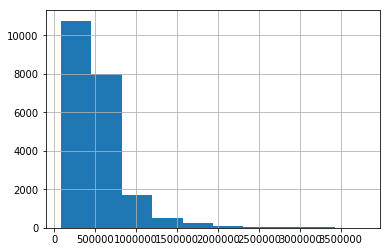

In [13]:
data.price.hist()

That's not exactly the kinda graph I'm hoping to see. There *has* to be something on the high end that's clumping everything on the left.

In [14]:
#Yo, there is an extra zero in play between 75% and max.
data.price.describe()

count    2.139600e+04
mean     5.347708e+05
std      3.397288e+05
min      7.800000e+04
25%      3.225000e+05
50%      4.500000e+05
75%      6.400000e+05
max      3.800000e+06
Name: price, dtype: float64

In [15]:
(data[data['price'] > data.price.quantile(.999)].price.mean()) / (data['price'].mean())

6.354463759872289

Checking on the mean of the top 0.001%, which ends up being 6.8x the price mean.

Let's remove the top and bottom 0.001% from price and see what it does.

In [16]:
data = data[data['price'] < data.price.quantile(.999)]
data = data[data['price'] > data.price.quantile(.001)]

In [17]:
# It doesn't do too much, but it does reduce the difference by 12%,
# which means the highest of highs were skewed more than the lowest of lows
(data[data['price'] > data.price.quantile(.999)].price.mean()) / (data['price'].mean())

5.617356780323623

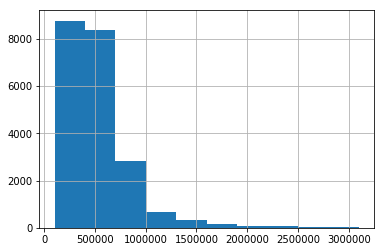

In [18]:
data.price.hist()

Let's check back in with our histogram.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1bbe65f8>,
      dtype=object)

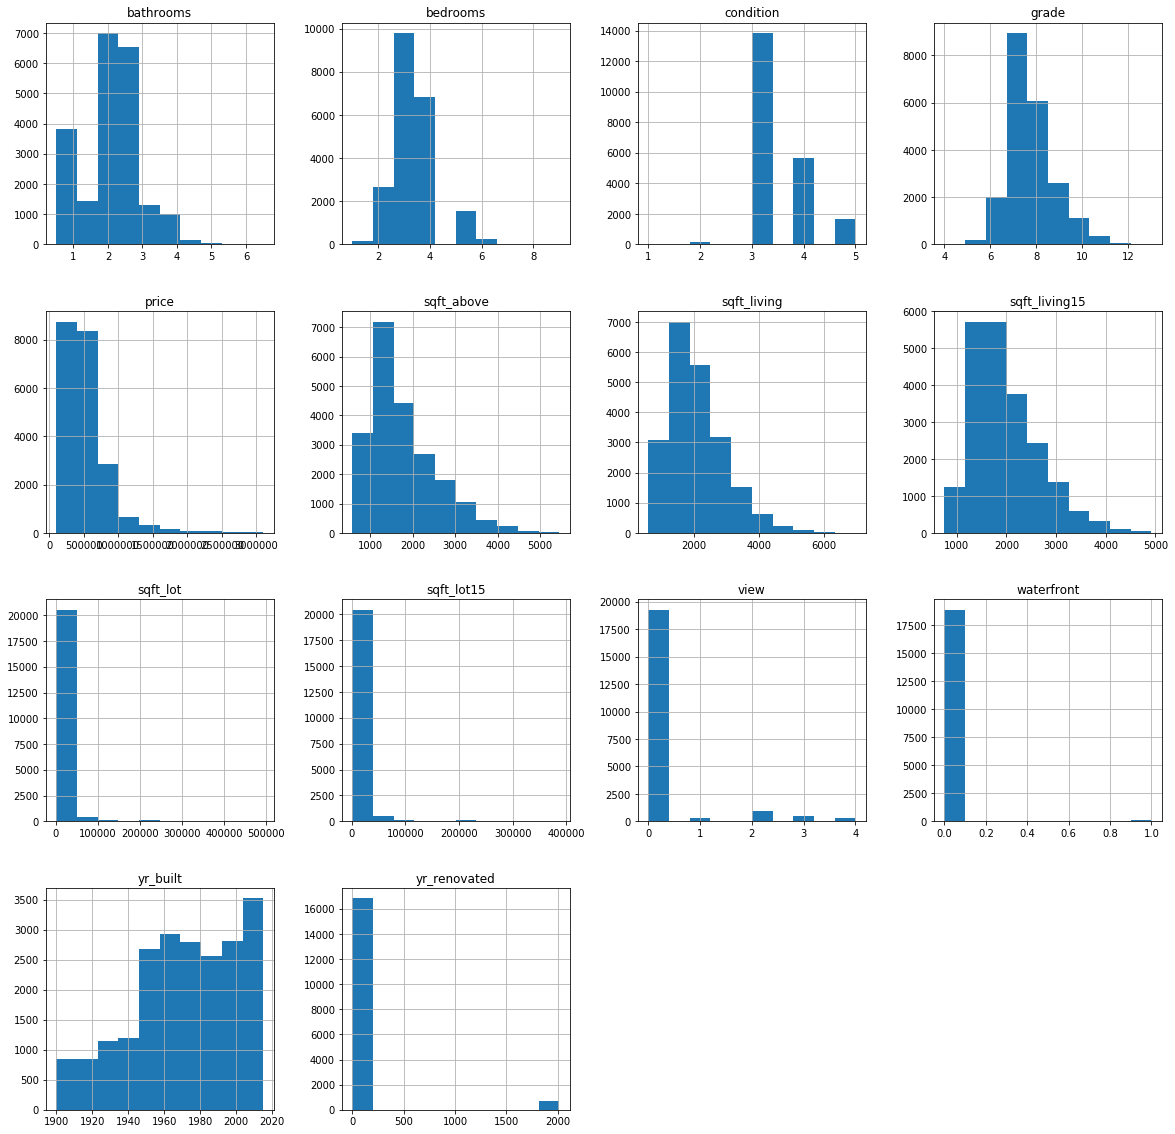

In [19]:
data.hist(figsize = (20,20))

# New Columns, New Me

I'm using my real world experience here to add a few stats that mattered to me when purchasing my apartment.
Price per usable square foot (above ground), bedrooms per bathroom, and size comparisons between nearest 15 and the home. What's the usable space, what's the bedroom to bathroom situation like, and let's keep up with the Jonses. Let's take a look at our new stats after we make them.

In [20]:
data['price_per_sqft'] = data['price'] / data['sqft_above']
data['bpb'] = data['bedrooms'] / data['bathrooms']
data['comp15_sqft_living'] = data['sqft_living'] / data['sqft_living15']
data['comp15_sqft_lot'] = data['sqft_lot'] / data['sqft_lot15']

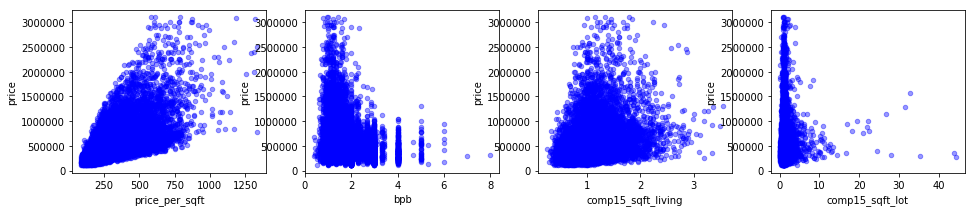

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['price_per_sqft', 'bpb', 'comp15_sqft_living', 'comp15_sqft_lot'], axes):
    data.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

In [22]:
data = data[data['comp15_sqft_lot'] < 15]
data = data[data['comp15_sqft_living'] < 4]
data = data[data['bpb'] < 6]
data = data[data['price_per_sqft'] < 1250]

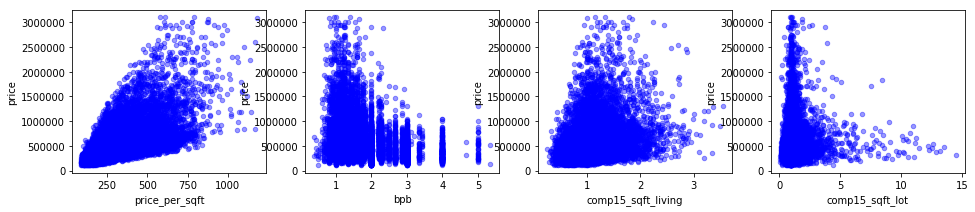

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))

for xcol, ax in zip(['price_per_sqft', 'bpb', 'comp15_sqft_living', 'comp15_sqft_lot'], axes):
    data.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

# Check for Null Values
There's a few, but no huge amounts. In all cases, I'm treating them like Boolean values, so these are as good as 0 to me. I'd rather fill these values than remove the rows.

In [24]:
data.isnull().sum()

date                     0
price                    0
bedrooms                 0
bathrooms                0
sqft_living              0
sqft_lot                 0
waterfront            2348
view                    62
condition                0
grade                    0
sqft_above               0
sqft_basement            0
yr_built                 0
yr_renovated          3786
sqft_living15            0
sqft_lot15               0
price_per_sqft           0
bpb                      0
comp15_sqft_living       0
comp15_sqft_lot          0
dtype: int64

In [25]:
# fill in null values
data['yr_renovated'].fillna(0, inplace = True)
data['waterfront'].fillna(0, inplace = True)
data['view'].fillna(0, inplace = True)

# Using the mode to fill in null values

I used the mode because I'm basically viewing the data as boolean. You were renovated or you weren't. You have a view or you don't. You're by the water or you're not. The histograms show the story here.

In [26]:
data.isnull().sum()

date                  0
price                 0
bedrooms              0
bathrooms             0
sqft_living           0
sqft_lot              0
waterfront            0
view                  0
condition             0
grade                 0
sqft_above            0
sqft_basement         0
yr_built              0
yr_renovated          0
sqft_living15         0
sqft_lot15            0
price_per_sqft        0
bpb                   0
comp15_sqft_living    0
comp15_sqft_lot       0
dtype: int64

There we go, but there's still one more stat I'd like to make, which was impossible while there was null values in the yr_renovated column. Say hello to the Years Since Renovation column. I create a list from absolute value of year renovated - year built, change anything above 800 to 0 since there has been no renovation and bring it back as a new column. I'm sure there's a better way to do this, but I'm crunched for time.

In [27]:
since_reno = list(abs(data['yr_renovated'] - data['yr_built']))
for i in range(len(since_reno)):
    if since_reno[i] >= 800:
        since_reno[i] = 0
    else:
        pass
data['since_reno'] = since_reno

In [28]:
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,price_per_sqft,bpb,comp15_sqft_living,comp15_sqft_lot,since_reno
0,10/13/2014,221900.0,3,1.00,1180,5650,0.0,0.0,3,7,...,0.0,1955,0.0,1340,5650,188.050847,3.000000,0.880597,1.000000,0.0
1,12/9/2014,538000.0,3,2.25,2570,7242,0.0,0.0,3,7,...,400.0,1951,1991.0,1690,7639,247.926267,1.333333,1.520710,0.948030,40.0
2,2/25/2015,180000.0,2,1.00,770,10000,0.0,0.0,3,6,...,0.0,1933,0.0,2720,8062,233.766234,2.000000,0.283088,1.240387,0.0
3,12/9/2014,604000.0,4,3.00,1960,5000,0.0,0.0,5,7,...,910.0,1965,0.0,1360,5000,575.238095,1.333333,1.441176,1.000000,0.0
4,2/18/2015,510000.0,3,2.00,1680,8080,0.0,0.0,3,8,...,0.0,1987,0.0,1800,7503,303.571429,1.500000,0.933333,1.076903,0.0


# The second round of column cuts

We have some new features and some we won't need anymore. Year renovated and year built aren't needed anymore beause we know if something was renovated or not and can derive when based on that column. Square footage has the most correlation, so that isn't useful, but I've created a new feature of price per square foot above ground, which acts in a similar fashion. Bedrooms and bathrooms aren't needed because of the bedrooms per bathrooms feature.

In [29]:
data.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       'sqft_lot15', 'price_per_sqft', 'bpb', 'comp15_sqft_living',
       'comp15_sqft_lot', 'since_reno'],
      dtype='object')

In [30]:
# After the fact I'm coming back and removing columns I'm not using.

data = data.drop(['yr_built', 'yr_renovated', 'sqft_living', 'bedrooms', 'bathrooms'], axis=1)

In [31]:
#this is just to keep my place
og_data = data

# I tried something that really didn't help here. Welceome to "shiny"

Curious if I can make something new and simplify a few stats. Shiny is the sum of a few of the statis that I feel make a difference but I'd still liek to simplify. Ultimately this wasnt helpful towards my goals.

data['shiny'] = data['waterfront'] + data['view'] + data['condition'] + data['grade']

outcome = 'price'
x_cols = ['shiny', 'price_per_sqft', 'bpb']
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=data).fit()
model.summary()

# Run OLS, cross fingers

In [32]:
outcome = 'price'
x_cols = ['waterfront', 'view', 'condition', 'grade', 'price_per_sqft', 'bpb']
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     9761.
Date:                Tue, 07 May 2019   Prob (F-statistic):               0.00
Time:                        16:34:28   Log-Likelihood:            -2.8674e+05
No. Observations:               21317   AIC:                         5.735e+05
Df Residuals:                   21310   BIC:                         5.735e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       -1.23e+06   1.26e+04    -97.285      0.000   -1.26e+06   -1.21e+06
waterfront      2.509e+05   1.64e+04     15.271      0.000    2.19e+05    2.83e+05
view            3.272e+04   1742.107     18.784      0.000    2.93e+04    3.61e+04
condition       1.709e+04   1843.892      9.268      0.000    1.35e+04    2.07e+04
grade            1.75e+05   1148.955    152.314      0.000    1.73e+05    1.77e+05
price_per_sqft  1092.8534      8.548    127.848      0.000    1076.099    1109.608
bpb             7832.9660   1963.338      3.990      0.000    3984.675    1.17e+04
==============================================================================
Omnibus:                     9999.732   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           127051.245
Skew:                           1.928   Prob(JB):                         0.00
Kurtosis:                      14.321   Cond. No.                     4.93e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

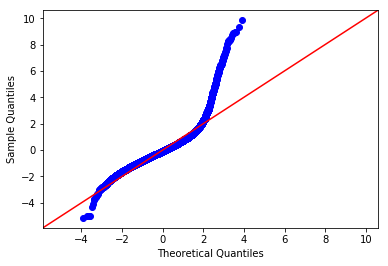

In [33]:
import scipy.stats as stats
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

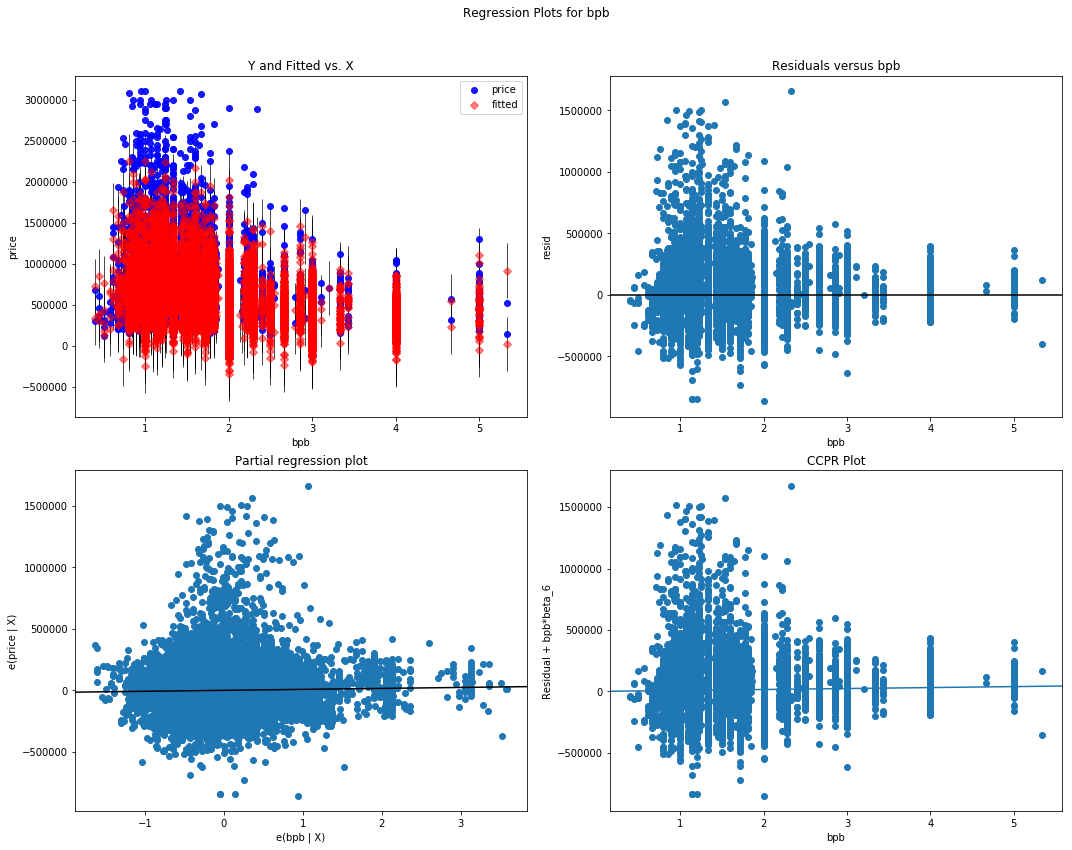

In [34]:
fig = plt.figure(figsize=(15,12))
fig = sm.graphics.plot_regress_exog(model, "bpb", fig=fig)
plt.show()

# This seems like a crazy idea, let's log the price!

So that QQ plot isn't quite where I want it to be.

In [35]:
non_normal = ['price']
for feat in non_normal:
    data[feat] = data[feat].map(lambda x: np.log(x))

In [36]:
# This raises the R-squared by 0.36, which nice,
# but you can see the waterfront's P>|t| is now 0.185

outcome = 'price'
x_cols = ['waterfront', 'view', 'condition', 'grade', 'price_per_sqft', 'bpb']
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                 1.181e+04
Date:                Tue, 07 May 2019   Prob (F-statistic):               0.00
Time:                        16:34:29   Log-Likelihood:                -326.15
No. Observations:               21317   AIC:                             666.3
Df Residuals:                   21310   BIC:                             722.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         10.2810      0.018    556.191      0.000      10.245      10.317
waterfront         0.0318      0.024      1.324      0.185      -0.015       0.079
view               0.0192      0.003      7.541      0.000       0.014       0.024
condition          0.0228      0.003      8.451      0.000       0.017       0.028
grade              0.2785      0.002    165.838      0.000       0.275       0.282
price_per_sqft     0.0019   1.25e-05    149.925      0.000       0.002       0.002
bpb               -0.0207      0.003     -7.223      0.000      -0.026      -0.015
==============================================================================
Omnibus:                       62.658   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               74.524
Skew:                           0.068   Prob(JB):                     6.57e-17
Kurtosis:                       3.256   Cond. No.                     4.93e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [75]:
#removing waterfront does not impact the R-squared
# and the P values stays at 0
outcome = 'price'
x_cols = ['view', 'condition', 'grade', 'price_per_sqft', 'bpb']
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                 1.557e+04
Date:                Tue, 07 May 2019   Prob (F-statistic):               0.00
Time:                        16:38:20   Log-Likelihood:                 447.88
No. Observations:               21317   AIC:                            -883.8
Df Residuals:                   21311   BIC:                            -836.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.3256      0.027    273.474      0.000       7.273       7.378
view               0.0322      0.002     14.054      0.000       0.028       0.037
condition          0.0759      0.009      8.153      0.000       0.058       0.094
grade              0.2750      0.002    170.087      0.000       0.272       0.278
price_per_sqft     0.6291      0.004    161.522      0.000       0.622       0.637
bpb               -0.0223      0.003     -8.041      0.000      -0.028      -0.017
==============================================================================
Omnibus:                      138.572   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.180
Skew:                           0.170   Prob(JB):                     6.66e-33
Kurtosis:                       3.226   Cond. No.                         164.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

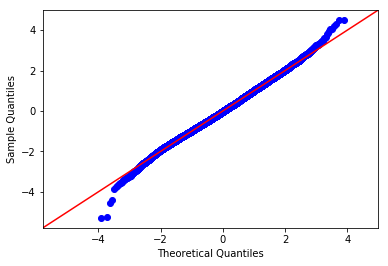

In [38]:
import scipy.stats as stats
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

#that is a MUCH friendlier QQ plot

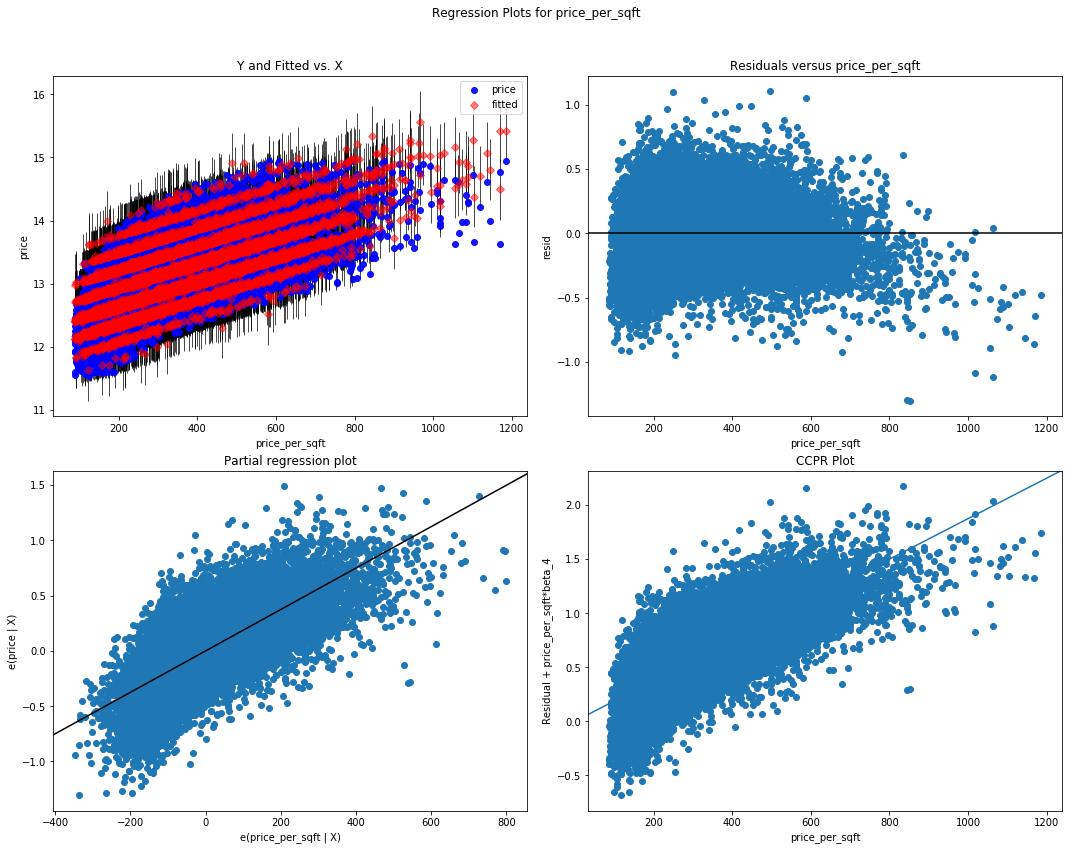

In [39]:
fig = plt.figure(figsize=(15,12))
fig = sm.graphics.plot_regress_exog(model, "price_per_sqft", fig=fig)
plt.show()

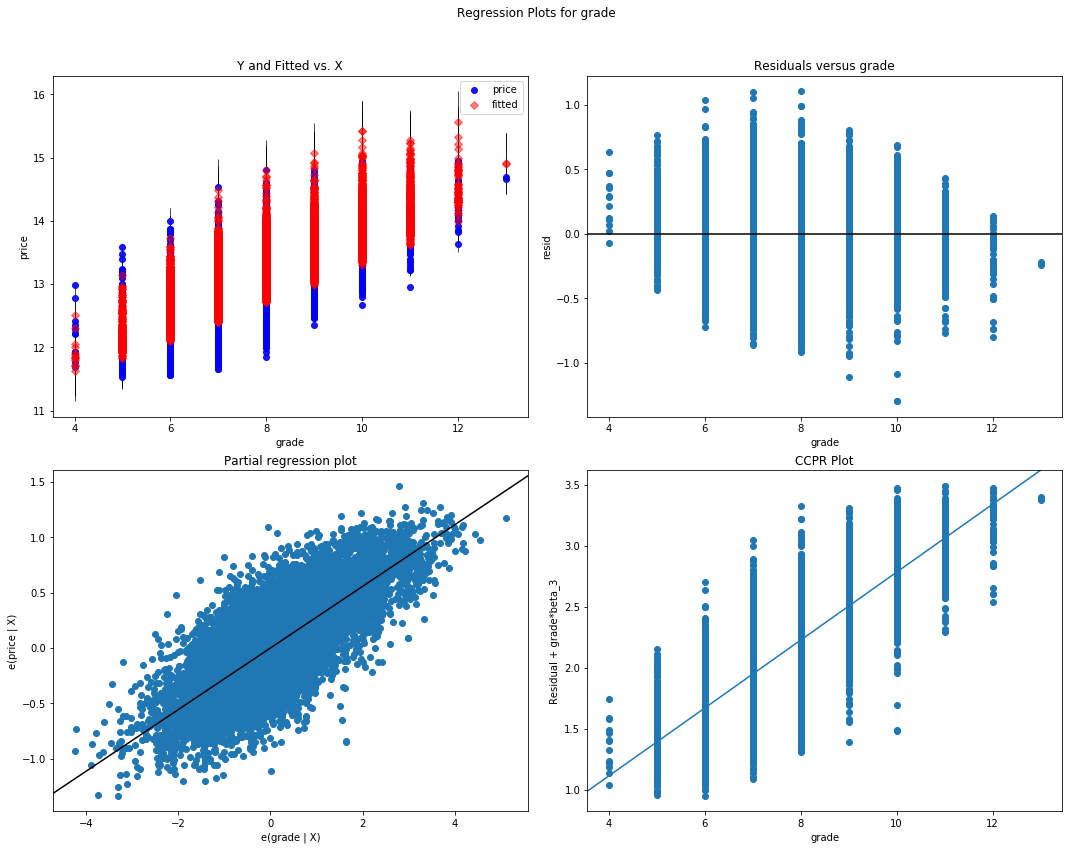

In [40]:
fig = plt.figure(figsize=(15,12))
fig = sm.graphics.plot_regress_exog(model, "grade", fig=fig)
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1d233320>,
      dtype=object)

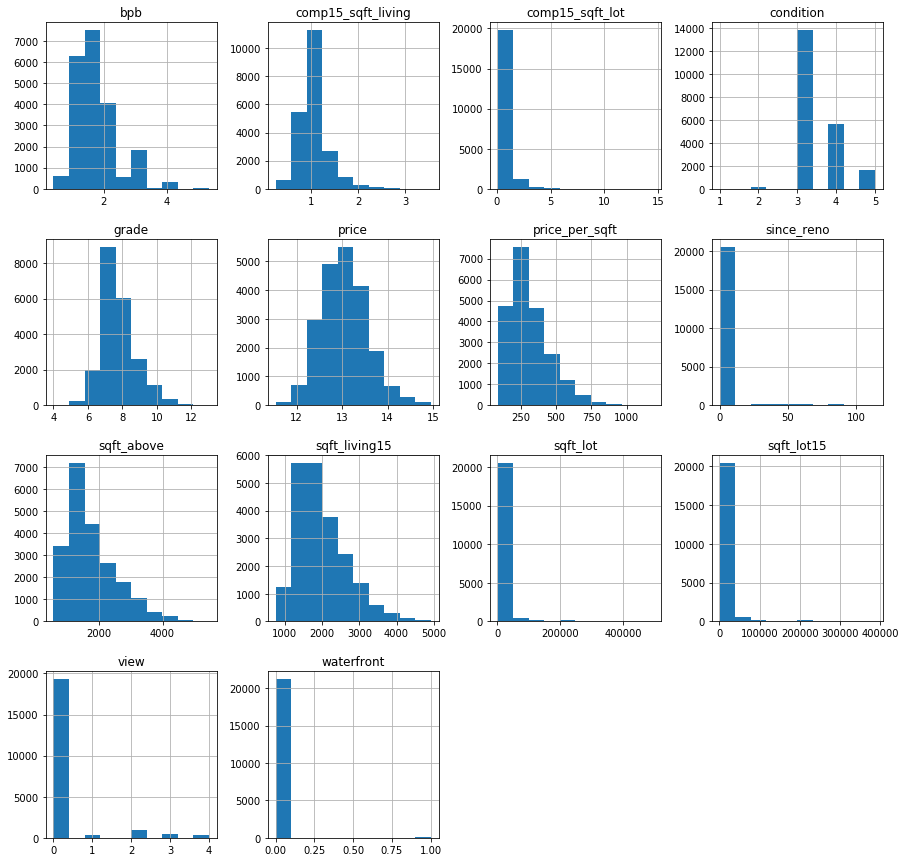

In [41]:
data.hist(figsize = (15,15))

# Log transform price per sqare foot 

In [42]:
non_normal = ['price_per_sqft']
for feat in non_normal:
    data[feat] = data[feat].map(lambda x: np.log(x))

In [74]:
#removing waterfront did not impact the R-squared, so I pulled it out
outcome = 'price'
x_cols = ['view', 'condition', 'grade', 'price_per_sqft', 'bpb']
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                 1.557e+04
Date:                Tue, 07 May 2019   Prob (F-statistic):               0.00
Time:                        16:37:34   Log-Likelihood:                 447.88
No. Observations:               21317   AIC:                            -883.8
Df Residuals:                   21311   BIC:                            -836.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.3256      0.027    273.474      0.000       7.273       7.378
view               0.0322      0.002     14.054      0.000       0.028       0.037
condition          0.0759      0.009      8.153      0.000       0.058       0.094
grade              0.2750      0.002    170.087      0.000       0.272       0.278
price_per_sqft     0.6291      0.004    161.522      0.000       0.622       0.637
bpb               -0.0223      0.003     -8.041      0.000      -0.028      -0.017
==============================================================================
Omnibus:                      138.572   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.180
Skew:                           0.170   Prob(JB):                     6.66e-33
Kurtosis:                       3.226   Cond. No.                         164.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

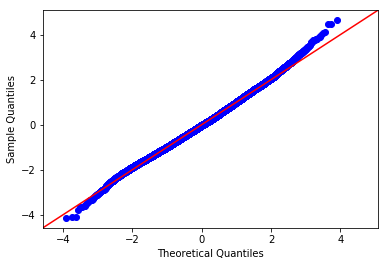

In [44]:
import scipy.stats as stats
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

#that is a MUCH friendlier QQ plot

In [45]:
data.columns

Index(['date', 'price', 'sqft_lot', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15',
       'price_per_sqft', 'bpb', 'comp15_sqft_living', 'comp15_sqft_lot',
       'since_reno'],
      dtype='object')

# Removing all columns I'm not using for the model

In [46]:
# this one is the snappening

data = data.drop(['date', 'sqft_lot', 'waterfront', 'sqft_above',
                  'sqft_basement', 'sqft_living15', 'sqft_lot15',
                  'comp15_sqft_living', 'comp15_sqft_lot', 'since_reno'], axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1ba5aa58>,
      dtype=object)

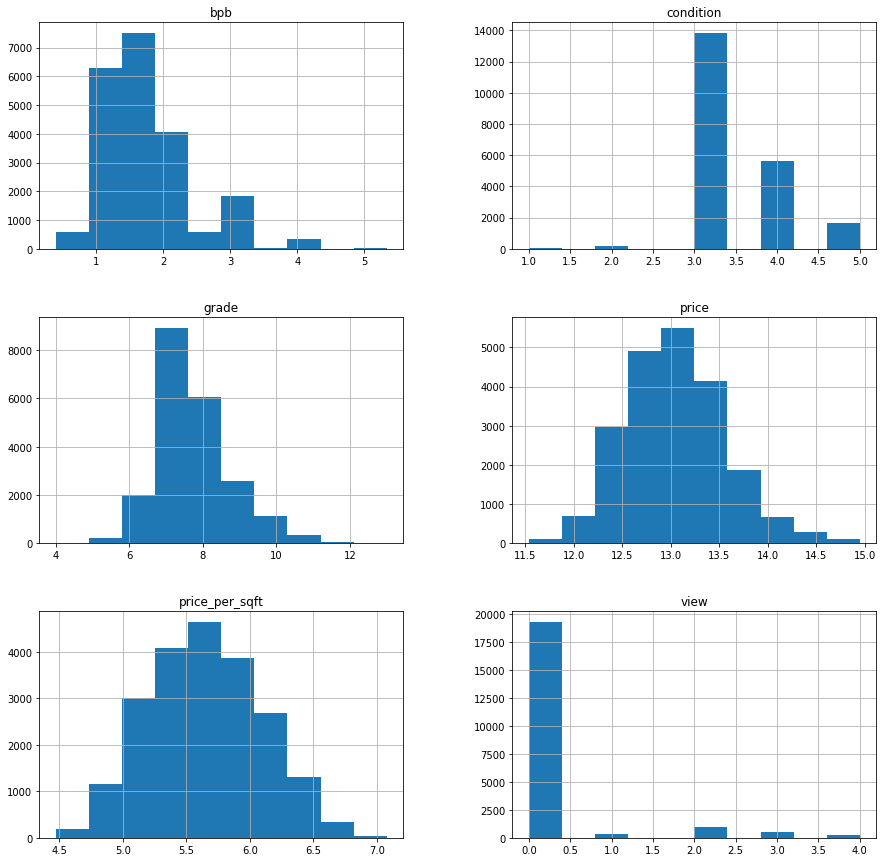

In [47]:
data.hist(figsize=(15,15))

In [48]:
non_normal = ['condition']
for feat in non_normal:
    data[feat] = data[feat].map(lambda x: np.log(x))

In [49]:
#removing waterfront does not impact the R-squared
outcome = 'price'
x_cols = ['view', 'condition', 'grade', 'price_per_sqft', 'bpb']
predictors = '+'.join(x_cols)
formula = outcome + "~" + predictors
model = ols(formula=formula, data=data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                 1.557e+04
Date:                Tue, 07 May 2019   Prob (F-statistic):               0.00
Time:                        16:34:36   Log-Likelihood:                 447.88
No. Observations:               21317   AIC:                            -883.8
Df Residuals:                   21311   BIC:                            -836.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.3256      0.027    273.474      0.000       7.273       7.378
view               0.0322      0.002     14.054      0.000       0.028       0.037
condition          0.0759      0.009      8.153      0.000       0.058       0.094
grade              0.2750      0.002    170.087      0.000       0.272       0.278
price_per_sqft     0.6291      0.004    161.522      0.000       0.622       0.637
bpb               -0.0223      0.003     -8.041      0.000      -0.028      -0.017
==============================================================================
Omnibus:                      138.572   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.180
Skew:                           0.170   Prob(JB):                     6.66e-33
Kurtosis:                       3.226   Cond. No.                         164.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Stepwise Selection

In [50]:
model_features = pd.DataFrame(data, columns = ['view', 'condition', 'grade', 'price_per_sqft', 'bpb'])

In [51]:
view = model_features['view']
condition = model_features['condition']
grade = model_features['grade']
price_per_sqft = model_features['price_per_sqft']
bpb = model_features['bpb']

In [52]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included


In [53]:
X = model_features
y = pd.DataFrame(data, columns= ["price"])


In [54]:
result = stepwise_selection(X, y, verbose = True)
print('resulting features:')
print(result)


Add  grade                          with p-value 0.0
Add  price_per_sqft                 with p-value 0.0
Add  view                           with p-value 9.88815e-47
Add  condition                      with p-value 5.0583e-14
Add  bpb                            with p-value 9.3455e-16
resulting features:
['grade', 'price_per_sqft', 'view', 'condition', 'bpb']


# Build the final model again in Statsmodels

In [55]:
X_fin = X[['view', 'condition', 'grade', 'price_per_sqft', 'bpb']]
X_int = sm.add_constant(X_fin)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                 1.557e+04
Date:                Tue, 07 May 2019   Prob (F-statistic):               0.00
Time:                        16:34:37   Log-Likelihood:                 447.88
No. Observations:               21317   AIC:                            -883.8
Df Residuals:                   21311   BIC:                            -836.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              7.3256      0.027    273.474      0.000       7.273       7.378
view               0.0322      0.002     14.054      0.000       0.028       0.037
condition          0.0759      0.009      8.153      0.000       0.058       0.094
grade              0.2750      0.002    170.087      0.000       0.272       0.278
price_per_sqft     0.6291      0.004    161.522      0.000       0.622       0.637
bpb               -0.0223      0.003     -8.041      0.000      -0.028      -0.017
==============================================================================
Omnibus:                      138.572   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              148.180
Skew:                           0.170   Prob(JB):                     6.66e-33
Kurtosis:                       3.226   Cond. No.                         164.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Use Feature ranking with recursive feature elimination

In [56]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 3)
selector = selector.fit(X, y)

In [57]:
selector.support_ 

array([False,  True,  True,  True, False])

In [58]:
selected_columns = X.columns[selector.support_ ]
linreg.fit(X[selected_columns],y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [59]:
yhat = linreg.predict(X[selected_columns])

In [60]:
SS_Residual = np.sum((y-yhat)**2)
SS_Total = np.sum((y-np.mean(y))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X[selected_columns].shape[1]-1)


In [61]:
r_squared

price    0.782372
dtype: float64

In [62]:
adjusted_r_squared

price    0.782342
dtype: float64

# Let's Train Test Some Data!

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [65]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

15987 5330 15987 5330


In [66]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

In [67]:
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [68]:
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [69]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [70]:
from sklearn.metrics import mean_squared_error

In [71]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)


Train Mean Squarred Error: 0.055889284781588916
Test Mean Squarred Error: 0.056927166774049104


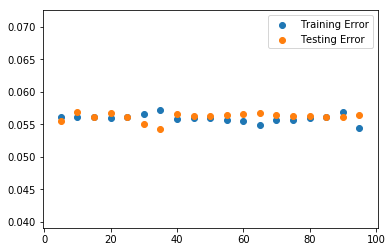

In [72]:
import random
random.seed(11)

train_err = []
test_err = []
t_sizes = list(range(5,100,5))
for t_size in t_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size/100)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend()


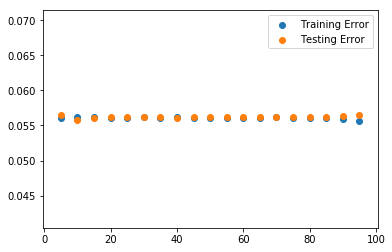

In [73]:
random.seed(8)

train_err = []
test_err = []
t_sizes = list(range(5,100,5))
for t_size in t_sizes:
    temp_train_err = []
    temp_test_err = []
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=t_size/100)
        linreg.fit(X_train, y_train)
        y_hat_train = linreg.predict(X_train)
        y_hat_test = linreg.predict(X_test)
        temp_train_err.append(mean_squared_error(y_train, y_hat_train))
        temp_test_err.append(mean_squared_error(y_test, y_hat_test))
    train_err.append(np.mean(temp_train_err))
    test_err.append(np.mean(temp_test_err))
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend()
